# Privacy-QoS Trade-Off Analysis

In [684]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Define method to get sub-datasets of the main dataset

In [685]:
def getSubDatasets(df):
    firstDf = df[(df["dummyLocation"]==False) & (df["gpsPerturbated"]==True)].reset_index(drop=True)
    secondDf = df[(df["dummyLocation"]==True) & (df["gpsPerturbated"]==False)].reset_index(drop=True)
    thirdDf = df[(df["dummyLocation"]==True) & (df["gpsPerturbated"]==True)].reset_index(drop=True)

    return [firstDf, secondDf, thirdDf]

Import privacy and qos datasets, define alphas

In [686]:
privacyDf = pd.read_csv((os.path.join('csvs', f'average_distances.csv')), index_col=[0])
qosDf = pd.read_csv((os.path.join('csvs', f'qos.csv')), index_col=[0])

alphas = [0, 0.2, 0.4, 0.6, 0.8, 1]

privacySubDf = getSubDatasets(privacyDf)
qosSubDf = getSubDatasets(qosDf)

Linear combination to achieve the tradeoff between privacy and qos

In [687]:
def linearCombination(alpha, privacy, qos):
    return alpha * privacy + (1-alpha) * qos

Define min-max scaling function

In [688]:
def minMaxScaling(df):
    min = np.min(df)
    max = np.max(df)

    return (df - min) / (max - min)


Min-max scaling of privacy and qos values of the main dataset

In [689]:
pValues = privacyDf["avg"]
qosValues = pd.Series([pow(el, -1) for el in qosDf["mse"]])

privacyScaled = minMaxScaling(pValues)
qosScaled = minMaxScaling(qosValues)


Min-max scaling of privacy and qos values of the sub-datasets

In [690]:
pSubDfValues = [df["avg"] for df in privacySubDf]
qosSubDfValues = [pd.Series([pow(el, -1) for el in df["mse"]]) for df in qosSubDf]

privacySDScaled = [minMaxScaling(values) for values in pSubDfValues]
qosSDScaled = [minMaxScaling(values) for values in qosSubDfValues]

Define trade-off getter

In [691]:
def getTradeOff(df1, df2, mainDf):
    dfs = [pd.DataFrame([linearCombination(alpha, val, df2[ind]) for ind, val in enumerate(df1)], columns=["values"]) for alpha in alphas]

    tradeOff = [np.max(df["values"]) for df in dfs]
    
    for i, df in enumerate(dfs):
        ind, = df.index[df["values"]==np.max(df["values"])]
        print("Alpha: ", alphas[i], "\tPrivacy-QoS tradeoff: ", mainDf["dumRadMin"][ind], " - ", mainDf["dumRadStep"][ind], " - ", mainDf["pertDec"][ind])

    return tradeOff

Compute Privacy-QoS trade-off

In [692]:
print("----------Complete Dataset----------")
privacyQos = getTradeOff(privacyScaled, qosScaled, qosDf)

privacyQosSD = []
for ind, df1 in enumerate(privacySDScaled):
    print("----------Sub-dataset", ind+1,"----------")
    privacyQosSD.append(getTradeOff(df1, qosSDScaled[ind], qosSubDf[ind]))

----------Complete Dataset----------
Alpha:  0 	Privacy-QoS tradeoff:  -1  -  -1  -  5
Alpha:  0.2 	Privacy-QoS tradeoff:  -1  -  -1  -  5
Alpha:  0.4 	Privacy-QoS tradeoff:  -1  -  -1  -  5
Alpha:  0.6 	Privacy-QoS tradeoff:  3000  -  2000  -  1
Alpha:  0.8 	Privacy-QoS tradeoff:  3000  -  2000  -  1
Alpha:  1 	Privacy-QoS tradeoff:  3000  -  2000  -  1
----------Sub-dataset 1 ----------
Alpha:  0 	Privacy-QoS tradeoff:  -1  -  -1  -  5
Alpha:  0.2 	Privacy-QoS tradeoff:  -1  -  -1  -  5
Alpha:  0.4 	Privacy-QoS tradeoff:  -1  -  -1  -  5
Alpha:  0.6 	Privacy-QoS tradeoff:  -1  -  -1  -  1
Alpha:  0.8 	Privacy-QoS tradeoff:  -1  -  -1  -  1
Alpha:  1 	Privacy-QoS tradeoff:  -1  -  -1  -  1
----------Sub-dataset 2 ----------
Alpha:  0 	Privacy-QoS tradeoff:  500  -  250  -  -1
Alpha:  0.2 	Privacy-QoS tradeoff:  500  -  250  -  -1
Alpha:  0.4 	Privacy-QoS tradeoff:  500  -  250  -  -1
Alpha:  0.6 	Privacy-QoS tradeoff:  3000  -  2000  -  -1
Alpha:  0.8 	Privacy-QoS tradeoff:  3000  -  

Plot of the Privacy-QoS analysis

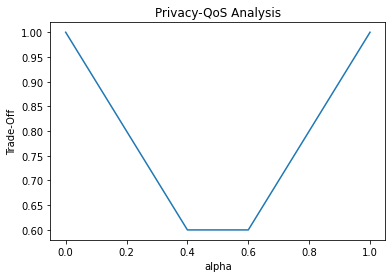

In [693]:
plt.plot(alphas, privacyQos)
plt.title("Privacy-QoS Analysis")
plt.xlabel("alpha")
plt.ylabel("Trade-Off")
plt.show()